In [1]:
### Load necessary libraries ###
import glob
import os
import librosa

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional


In [2]:
### Define helper functions ###
def extract_features(parent_dir, sub_dirs, file_ext="*.wav", 
                     bands=60, frames=41):
    
    def _windows(data, window_size):
        start = 0
        while start < len(data):
            yield start, start + window_size
            start += (window_size // 2)    

    window_size = 512 * (frames - 1)
    features, labels = [], []

    for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
        # For each file, load and turn into spectrograms according to windows
        segment_mfcc, segment_labels = [], []
        sound_clip, sr = librosa.load(fn)
        label = int(fn.split('/')[2].split('-')[1])
        for (start,end) in _windows(sound_clip,window_size):
            if(len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]
                # mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=bands) #.T.flatten()[:, np.newaxis].T
                # segment_mfcc.append(mfcc)
                # segment_labels.append(label)
                melspec = librosa.feature.melspectrogram(signal,n_mels=bands)
                S_dB = librosa.amplitude_to_db(melspec, ref=np.max)
                logspec = S_dB.flatten()[:, np.newaxis]
                segment_mfcc.append(logspec)
                segment_labels.append(label)
                
        # (7x41x20) For a 4 second clip, turn into 7 frames
        

        # Unclear why to reshape into same shape...?
        # segment_mfcc = np.asarray(segment_mfcc).reshape(
        #     len(segment_mfcc),frames,bands)
        
        # Append into (n, (7,41,20)) ish array
        if len(segment_mfcc) > 0 : # check for empty segments 
            features.append(segment_mfcc)
            labels.append(segment_labels) 
            
    return features, labels

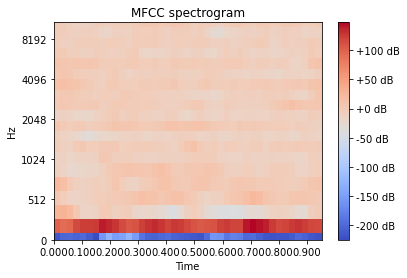

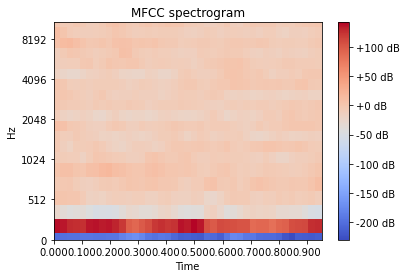

In [23]:
# # MFCC is questionable??

# import librosa.display
# import matplotlib.pyplot as plt

# files = ['UrbanSounds8K/audio/fold1\\105415-2-0-19.wav', 'UrbanSounds8K/audio/fold1\\105415-2-0-21.wav']
# segment_mfcc, segment_labels = [], []

# for fn in files:
#     start = 0
#     end = 512*40
#     bands = 20

#     sound_clip,sr = librosa.load(fn)
#     signal = sound_clip[start:end]
#     label = int(fn.split('/')[2].split('-')[1])
#     fig, ax = plt.subplots()

#     # melspec = librosa.feature.melspectrogram(signal,n_mels=bands)
#     # S_dB = librosa.amplitude_to_db(melspec, ref=np.max)
#     # logspec = S_dB.flatten()[:, np.newaxis]
#     signal = sound_clip[start:end]
#     mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=bands) #.T.flatten()[:, np.newaxis].T
#     img = librosa.display.specshow(mfcc, x_axis='time',
#                             sr=sr, y_axis='mel', #fmax=8000,
#                             ax=ax)

#     fig.colorbar(img, ax=ax, format='%+2.0f dB')
#     ax.set(title='MFCC spectrogram')
#     # segment_log_specgrams.append(logspec)
#     # segment_labels.append(label)
#     segment_mfcc.append(mfcc)
#     segment_labels.append(label)


# # np.shape(segment_log_specgrams) = (2, 1, 2460)


In [3]:
parent_dir = 'UrbanSounds8K/audio/'
save_dir = "UrbanSounds8K/processed_crnn/"
folds = sub_dirs = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'])
for sub_dir in sub_dirs:
    features, labels = extract_features(parent_dir,sub_dir)
    np.savez("{0}{1}".format(save_dir, sub_dir), features=features, 
             labels=labels)
    print(np.shape(features[0]))

C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\numpy\lib\npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


(7, 2460, 1)
(7, 2460, 1)
(7, 2460, 1)
(5, 2460, 1)
(7, 2460, 1)
(7, 2460, 1)
(7, 2460, 1)
(4, 2460, 1)
(7, 2460, 1)
(1, 2460, 1)


In [ ]:
### Define GRU based recurrent network architecture ###
def get_network():
    # num_filters = [24,32,64,128] 
    pool_size = (2, 2) 
    kernel_size = (3, 3)  
    input_shape = (60, 41, 2)
    num_classes = 10
    keras.backend.clear_session()
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(24, kernel_size,
                padding="same", input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    model.add(keras.layers.Dropout(.2))

    model.add(keras.layers.Conv2D(32, kernel_size,
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))  
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    model.add(keras.layers.Dropout(.2))
    
    model.add(keras.layers.Conv2D(64, kernel_size,
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))  
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    model.add(keras.layers.Dropout(.2))
    
    model.add(keras.layers.Conv2D(128, kernel_size,
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))  
    model.add(keras.layers.Dropout(.2))

    # # model.add(keras.layers.GlobalMaxPooling2D())
    # (None, 7, 5, 128)
    # (batch_size, timesteps, input_dim)
    model.add(tf.keras.layers.Reshape((35,128), input_shape=(7,5,128)))
    input_shape = (35, 128)
    model.add(keras.layers.LSTM(128, input_shape=input_shape))

    # model.add(keras.layers.GRU(128, input_shape=input_shape))

    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(1e-4), 
        loss=keras.losses.SparseCategoricalCrossentropy(), 
        metrics=["accuracy"])
        
    return model

# def get_network():
#     input_shape = (41, 20)
#     num_classes = 10
#     keras.backend.clear_session()
    
#     model = keras.models.Sequential()
#     model.add(keras.layers.GRU(128, input_shape=input_shape))
#     model.add(keras.layers.Dense(128, activation="relu"))
#     model.add(keras.layers.Dense(num_classes, activation = "softmax"))
#     model.compile(optimizer=keras.optimizers.Adam(1e-4), 
#         loss=keras.losses.SparseCategoricalCrossentropy(), 
#         metrics=["accuracy"])
    
#     return model
model = get_network()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 41, 24)        456       
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 41, 24)        96        
_________________________________________________________________
activation (Activation)      (None, 60, 41, 24)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 20, 24)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 20, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 20, 32)        6944      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 20, 32)        1

In [ ]:
## Not working
from tensorflow import keras
from tensorflow.keras import layers


def vgg_style(x):
    """
    The original feature extraction structure from CRNN paper.
    Related paper: https://ieeexplore.ieee.org/abstract/document/7801919
    """
    x = layers.Conv2D(
        64, 3, padding='same', activation='relu', name='conv1')(x)
    x = layers.MaxPool2D(pool_size=2, padding='same', name='pool1')(x)

    x = layers.Conv2D(
        128, 3, padding='same', activation='relu', name='conv2')(x)
    x = layers.MaxPool2D(pool_size=2, padding='same', name='pool2')(x)

    x = layers.Conv2D(256, 3, padding='same', use_bias=False, name='conv3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Activation('relu', name='relu3')(x)
    x = layers.Conv2D(
        256, 3, padding='same', activation='relu', name='conv4')(x)
    x = layers.MaxPool2D(
        pool_size=2, strides=(2, 1), padding='same', name='pool4')(x)

    x = layers.Conv2D(512, 3, padding='same', use_bias=False, name='conv5')(x)
    x = layers.BatchNormalization(name='bn5')(x)
    x = layers.Activation('relu', name='relu5')(x)
    x = layers.Conv2D(
        512, 3, padding='same', activation='relu', name='conv6')(x)
    x = layers.MaxPool2D(
        pool_size=2, strides=(2, 1), padding='same', name='pool6')(x)

    x = layers.Conv2D(512, 2, use_bias=False, name='conv7')(x)
    x = layers.BatchNormalization(name='bn7')(x)
    x = layers.Activation('relu', name='relu7')(x)

    x = layers.Reshape((-1, 512), name='reshape7')(x)
    return x


def build_model(num_classes,
                weight=None,
                preprocess=None,
                postprocess=None,
                img_shape=(60, 41, 1),
                model_name='crnn'):
                
    # keras.backend.clear_session()
    # model = keras.models.Sequential()
    x = img_input = keras.Input(shape=img_shape)
    if preprocess is not None:
        x = preprocess(x)
    
    x = vgg_style(x)
    x = layers.Bidirectional(
        layers.LSTM(units=256, return_sequences=True), name='bi_lstm1')(x)
    x = layers.Bidirectional(
        layers.LSTM(units=256, return_sequences=True), name='bi_lstm2')(x)
    x = layers.Dense(units=num_classes, name='logits')(x)
    
    if postprocess is not None:
        x = postprocess(x)

    model = keras.Model(inputs=img_input, outputs=x, name=model_name)
    if weight is not None:
        model.load_weights(weight, by_name=True, skip_mismatch=True)
    
    model.compile(optimizer=keras.optimizers.Adam(1e-4), 
        loss=keras.losses.SparseCategoricalCrossentropy(), 
        metrics=["accuracy"])
    
    return model
        

model = build_model(10)
model.summary()

Model: "crnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 41, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 41, 64)        640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 30, 21, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 30, 21, 128)       73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 15, 11, 128)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 15, 11, 256)       294912    
_________________________________________________________________
bn3 (BatchNormalization)     (None, 15, 11, 256)       1024   

In [ ]:
### Train and evaluate via 10-Folds cross-validation ###
accuracies = []
folds = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'])
load_dir = "UrbanSounds8K/processed/"
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(folds):
    x_train, y_train = [], []
    for ind in train_index:
        # read features or segments of an audio file
        train_data = np.load("{0}/{1}.npz".format(load_dir,folds[ind]), 
                       allow_pickle=True)
        # for training stack all the segments so that they are treated as an example/instance
        features = np.concatenate(train_data["features"], axis=0) 
        labels = np.concatenate(train_data["labels"], axis=0)
        x_train.append(features)
        y_train.append(labels)
    # stack x,y pairs of all training folds 
    x_train = np.concatenate(x_train, axis = 0).astype(np.float32)
    y_train = np.concatenate(y_train, axis = 0).astype(np.float32)
    
    # for testing we will make predictions on each segment and average them to 
    # produce signle label for an entire sound clip.
    test_data = np.load("{0}/{1}.npz".format(load_dir,
                   folds[test_index][0]), allow_pickle=True)
    x_test = test_data["features"]
    y_test = test_data["labels"]
    
    model = get_network()
    # model = build_model(10)
    model.fit(x_train, y_train, epochs = 3, batch_size = 24, verbose = 0)
    
    # evaluate on test set/fold
    y_true, y_pred = [], []
    for x, y in zip(x_test, y_test):
        # average predictions over segments of a sound clip
        avg_p = np.argmax(np.mean(model.predict(x), axis = 0))
        y_pred.append(avg_p) 
        # pick single label via np.unique for a sound clip
        y_true.append(np.unique(y)[0]) 
    accuracies.append(accuracy_score(y_true, y_pred))   
print("Average 10 Folds Accuracy: {0}".format(np.mean(accuracies)))

KeyboardInterrupt: 